<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/proof/CNN_proof_2024-07-16/CNN_model_depth_4_with_attention(all_diseases).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

In [ ]:
import pandas as pd

In [ ]:
import pickle

In [ ]:
import json
import os

In [ ]:
import numpy as np

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# loading data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/proof/corn_plant_dataset'

In [ ]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/proof/corn_plant_dataset')

In [ ]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=123,
    batch_size=32,
    image_size=(224, 224),
    )

Found 3852 files belonging to 4 classes.
Using 3082 files for training.
Using 770 files for validation.


In [ ]:
for batch in train_ds.take(1):
    images, labels = batch
    print(images.shape)  # Should be (32, 224, 224, 3) if batch size is 32
    print(labels.shape)

(32, 224, 224, 3)
(32,)


In [ ]:
class_names = train_ds.class_names
class_names

['Common_rust', 'Gray_leaf_spot', 'Northern_Leaf_Blight', 'healthy']

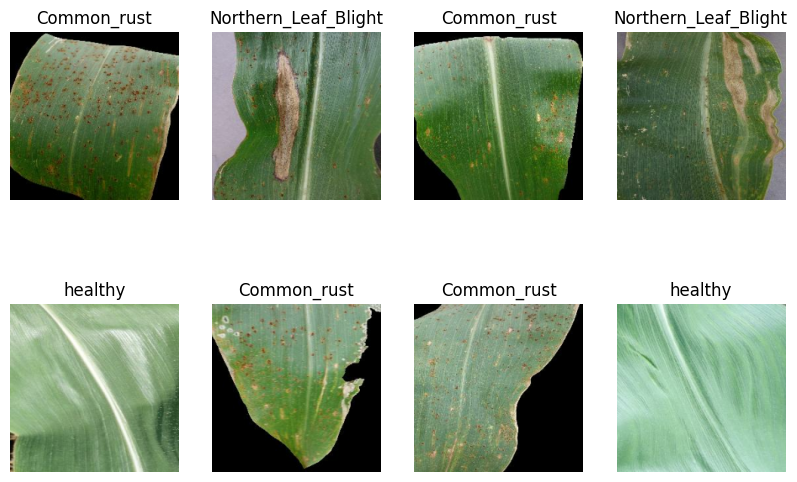

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## divide validation set to test & validation

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))


Number of validation batches: 25


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 5


# parameters and augmentations

In [ ]:
resize_and_rescale = keras.Sequential([
  keras.layers.Resizing(224, 224),
  keras.layers.Rescaling(1./127.5, offset=-1),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
no_of_classes = len(class_names)
no_of_classes

4

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [ ]:
epochs = 150

# Attention layer

In [ ]:
@tf.keras.utils.register_keras_serializable()
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
        attention_map = self.conv(concat)
        return inputs * attention_map

# model

In [ ]:
def create_model():
    inputs = layers.Input(shape=input_shape)
    x = resize_and_rescale(inputs)
    x = data_augmentation(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Add Spatial Attention layer here
    x = SpatialAttention()(x)

    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(no_of_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    mode='min',
                                                    patience=5,
                                                    restore_best_weights=True
                                                    )

# Training, Save and evaluation functions

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/proof/CNN_proof_2024-07-16/models'

In [ ]:
model = create_model()
history = model.fit(
                    train_ds,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_dataset,
                    verbose=1,
                    epochs=epochs,
                    callbacks=[early_stopping]
                    )

model.save(os.path.join(model_path, f'model_depth_{4}.keras'))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                           

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

5/5 [==============================] - 1s 106ms/step - loss: 0.1980 - accuracy: 0.9375


In [ ]:
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 0.9375
Test loss: 0.1980043351650238


# loading model(if needed)

In [ ]:
#model = create_model()

In [ ]:
model = tf.keras.models.load_model(os.path.join(model_path, f'model_depth_{4}.keras'))

# predictions

In [ ]:
predictions = model.predict(test_dataset)

5/5 [==============================] - 1s 113ms/step


In [ ]:
predictions

array([[6.86284111e-05, 9.72332358e-01, 2.75947209e-02, 4.22691073e-06],
       [1.36887456e-06, 1.13096119e-08, 1.72594227e-07, 9.99998450e-01],
       [2.05171432e-07, 2.70535860e-09, 1.76751715e-08, 9.99999762e-01],
       [5.93388904e-07, 4.56438611e-05, 9.99951243e-01, 2.51872416e-06],
       [1.59810204e-03, 7.10281134e-02, 9.23279762e-01, 4.09406610e-03],
       [5.83518613e-07, 4.44668746e-09, 5.40567626e-08, 9.99999404e-01],
       [3.34832976e-07, 5.14498399e-09, 5.12487937e-08, 9.99999642e-01],
       [1.00000000e+00, 2.59025210e-08, 1.34155342e-09, 4.27424989e-14],
       [9.99999404e-01, 5.67844211e-07, 9.83027770e-10, 2.97119607e-10],
       [7.77257992e-06, 1.01867951e-02, 9.89805460e-01, 3.21935509e-08],
       [1.19338006e-06, 4.77214357e-09, 8.03541695e-08, 9.99998689e-01],
       [9.99999285e-01, 7.00949784e-07, 1.28397948e-09, 3.95400699e-13],
       [9.99974251e-01, 2.57514039e-05, 1.03430309e-09, 2.66254119e-12],
       [1.72877244e-05, 1.68493092e-01, 8.31489503e

In [ ]:
y_pred_classes = np.argmax(predictions, axis=1)
y_pred_classes

array([1, 3, 3, 2, 2, 3, 3, 0, 0, 2, 3, 0, 0, 2, 2, 2, 0, 3, 2, 3, 0, 0,
       0, 2, 3, 3, 2, 3, 2, 2, 2, 0, 3, 3, 1, 3, 0, 0, 0, 2, 1, 0, 1, 2,
       0, 2, 3, 3, 3, 3, 1, 0, 3, 0, 3, 1, 3, 1, 2, 0, 0, 0, 2, 2, 0, 2,
       3, 0, 2, 3, 3, 0, 3, 0, 0, 1, 1, 2, 2, 0, 1, 2, 3, 0, 3, 2, 3, 0,
       3, 2, 3, 2, 1, 0, 0, 3, 0, 0, 0, 1, 1, 3, 2, 1, 1, 2, 1, 0, 0, 2,
       3, 3, 0, 3, 0, 2, 0, 0, 3, 2, 0, 3, 0, 3, 2, 2, 2, 3, 0, 2, 0, 0,
       0, 1, 0, 3, 3, 3, 0, 2, 2, 3, 3, 0, 3, 3, 0, 3, 3, 3, 2, 3, 0, 0,
       0, 0, 0, 3, 1, 0])

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true

array([1, 3, 3, 2, 2, 3, 3, 0, 0, 2, 3, 0, 0, 1, 1, 2, 0, 3, 2, 3, 0, 0,
       0, 2, 3, 3, 2, 3, 2, 2, 2, 0, 3, 3, 1, 3, 0, 0, 0, 2, 1, 0, 1, 2,
       0, 2, 3, 3, 3, 3, 1, 0, 3, 0, 3, 1, 3, 1, 2, 0, 0, 0, 2, 2, 0, 1,
       3, 0, 2, 3, 1, 0, 3, 0, 0, 2, 1, 1, 2, 0, 2, 2, 3, 0, 3, 2, 3, 0,
       3, 2, 3, 2, 1, 0, 0, 3, 0, 0, 0, 1, 2, 3, 2, 1, 1, 2, 1, 0, 0, 2,
       3, 3, 0, 3, 0, 2, 0, 0, 3, 1, 0, 3, 1, 3, 2, 2, 2, 3, 0, 2, 0, 0,
       0, 1, 0, 3, 3, 3, 0, 2, 2, 3, 3, 0, 3, 3, 0, 3, 3, 3, 2, 3, 0, 0,
       0, 0, 0, 3, 1, 0], dtype=int32)

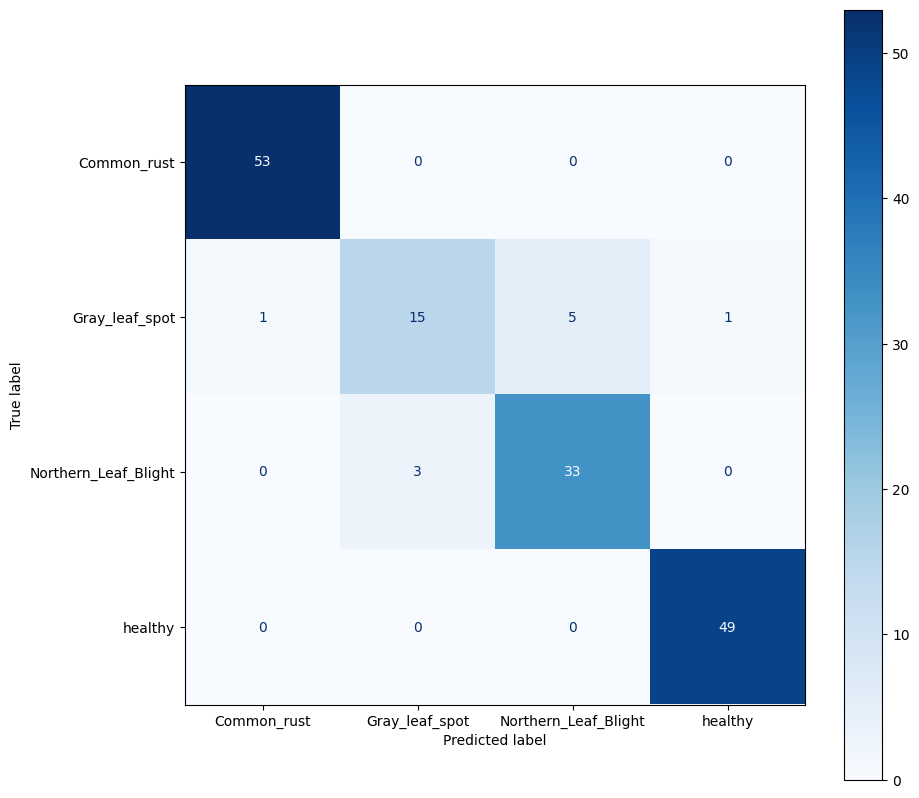

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

# Grad-CAM activation  visualization

In [ ]:
import numpy as np

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
from PIL import Image as PILImage

In [ ]:
img_size = (224, 224)

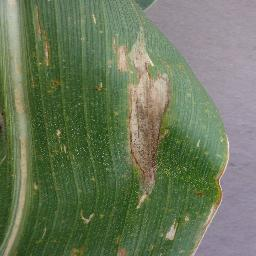

In [ ]:
# Path to your image in Google Drive
img_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/imgs/Blight/Corn_Blight (123).JPG'

display(Image(img_path))

In [ ]:
img_size = (224, 224)

In [ ]:
last_conv_layer_name = "conv2d_10"

## The Grad-CAM algorithm

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# test 1

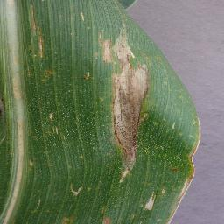

In [ ]:
img = load_img(img_path, target_size=img_size)
img

In [ ]:
preds = model.predict(np.expand_dims(img, axis=0))
print("Predicted:", class_names[np.argmax(preds[0])])

1/1 [==============================] - 0s 28ms/step
Predicted: Northern_Leaf_Blight


1/1 [==============================] - 0s 19ms/step
Predicted: Northern_Leaf_Blight


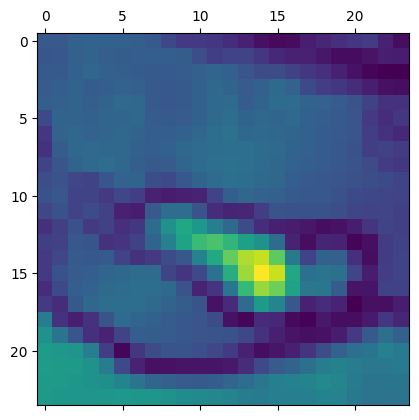

In [ ]:
# Prepare image
# img_array = preprocess_input(get_img_array(img_path, size=img_size))
img = load_img(img_path, target_size=img_size)
img_array = img_to_array(img)

# Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(np.expand_dims(img, axis=0))
print("Predicted:", class_names[np.argmax(preds[0])])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(np.expand_dims(img_array, axis=0), model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## Create a superimposed visualization

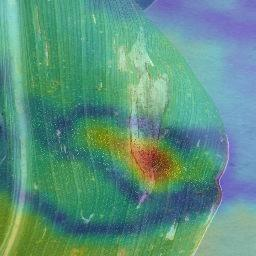

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

# test 2

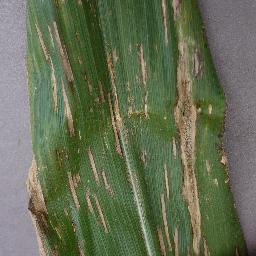

In [ ]:
# Path to your image in Google Drive
img_2_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/imgs/Gray_Leaf_Spot/image (513).JPG'

display(Image(img_2_path))

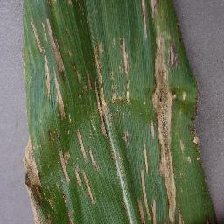

In [ ]:
img2 = load_img(img_2_path, target_size=img_size)
img2

In [ ]:
preds2 = model.predict(np.expand_dims(img2, axis=0))
print("Predicted:", class_names[np.argmax(preds2[0])])

1/1 [==============================] - 0s 19ms/step
Predicted: Gray_leaf_spot


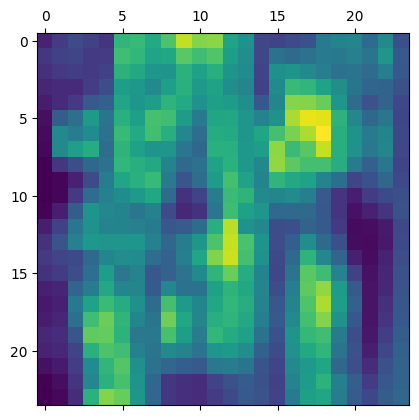

In [ ]:
img2_array = img_to_array(img2)

# Remove last layer's softmax
# model.layers[-1].activation = None          #removed before

# Print what the top predicted class is
# preds = model.predict(np.expand_dims(img, axis=0))
# print("Predicted:", class_names[np.argmax(preds[0])])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(np.expand_dims(img2_array, axis=0), model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

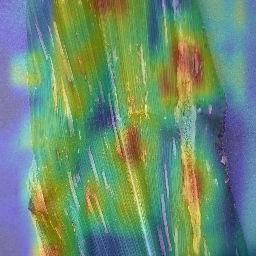

In [ ]:
save_and_display_gradcam(img_2_path, heatmap)